In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

pd.set_option('display.max_rows', 60)

In [123]:
# setting values

path = "../Datasets/train - new file - 20230223 130159135.csv"
n_targets = 8

In [124]:
# reading from the file dropping nan values
names = ['timestamp', 
        'id', 
        'x', 'y', 'z', 
        'head orientation', 
        'body orientation', 
        'true target', 
        'probability 0',
        'probability 1',
        'probability 2',
        'probability 3',
        'probability 4',
        'probability 5',
        'probability 6',
        'probability 7',
        ]
df = pd.read_csv(path, header=None, names=names)
df.dropna(inplace=True)

In [125]:
# adding the predicted target as a new column
def pred(x):
    pred = x[-n_targets:].copy().astype(float).reset_index(drop=True).idxmax()
    return pred
    
df["prediction target"] = df.apply(lambda x: pred(x), axis=1)
df["similarity"] = df.apply(lambda x: 1 if x["true target"] == x["prediction target"] else 0, axis=1)

In [126]:
n_trials = len(df[['timestamp', 'id']].drop_duplicates())
print("The number of trials are: ", n_trials)

trials_targets = df[['timestamp', 'id', 'true target']].drop_duplicates()
trials_targets = trials_targets.groupby(['true target'])['id'].count()
print("The number of trials for each target:")
print(trials_targets.to_frame())

The number of trials are:  587
The number of trials for each target:
             id
true target    
0            69
1            73
2            82
3            84
4            77
5            68
6            68
7            66


In [127]:
timestamp = df[['timestamp']].drop_duplicates()

columns=["timestamp", 
         "trial points", 
         "accuracy", 
         "target", 
         "predicted targets", 
         "#predicted targets",
         "#predicted targets/length %"]

accu = pd.DataFrame(columns=columns)

for index, t in timestamp.iterrows():
    trial = df[df["timestamp"] == t["timestamp"]]
    accuracy = trial["similarity"].sum() / len(trial)
    target = trial["true target"].unique() 
    predicted_targets = trial["prediction target"].unique()

    match = trial[trial["true target"] == trial["prediction target"]]
    first_match_index = match.index[0] + 1 if not match.empty else trial.index[-1] + 1
    wrong = first_match_index - trial.index[0]

    row = {"timestamp": [t["timestamp"]], 
           "trial points": [len(trial)], 
           "accuracy": [accuracy],
           "target": target,
           "predicted targets" : [predicted_targets],
           "#predicted targets" : [len(predicted_targets)],
           "#predicted targets/length %" : [len(predicted_targets) / len(trial) * 100],
           "wrong prediction time till correct": wrong,
           "wrong prediction time till correct/length": wrong / len(trial)
           }

    accu = pd.concat([accu, pd.DataFrame(row)], ignore_index=True)    

accu[["trial points", "target", "#predicted targets"]] = accu[["trial points", "target", "#predicted targets"]].astype(str).astype(int)
accu.head()


,timestamp,trial points,accuracy,target,predicted targets,#predicted targets,#predicted targets/length %,wrong prediction time till correct,wrong prediction time till correct/length
0,2/23/2023 1:02:18 PM,416,0.307692,7,"[7, 5, 6]",3,0.721154,1.0,0.002404
1,2/23/2023 1:02:31 PM,584,0.265411,5,"[2, 6, 5]",3,0.513699,430.0,0.736301
2,2/23/2023 1:02:34 PM,71,0.394366,0,"[2, 0]",2,2.816901,30.0,0.422535
3,2/23/2023 1:02:42 PM,379,0.643799,5,"[2, 3, 1, 4, 7, 5, 6]",7,1.846966,50.0,0.131926
4,2/23/2023 1:02:51 PM,401,0.082294,4,"[2, 4, 1, 5, 6]",5,1.246883,18.0,0.044888


### Number of predicted targets in relation to trial length 

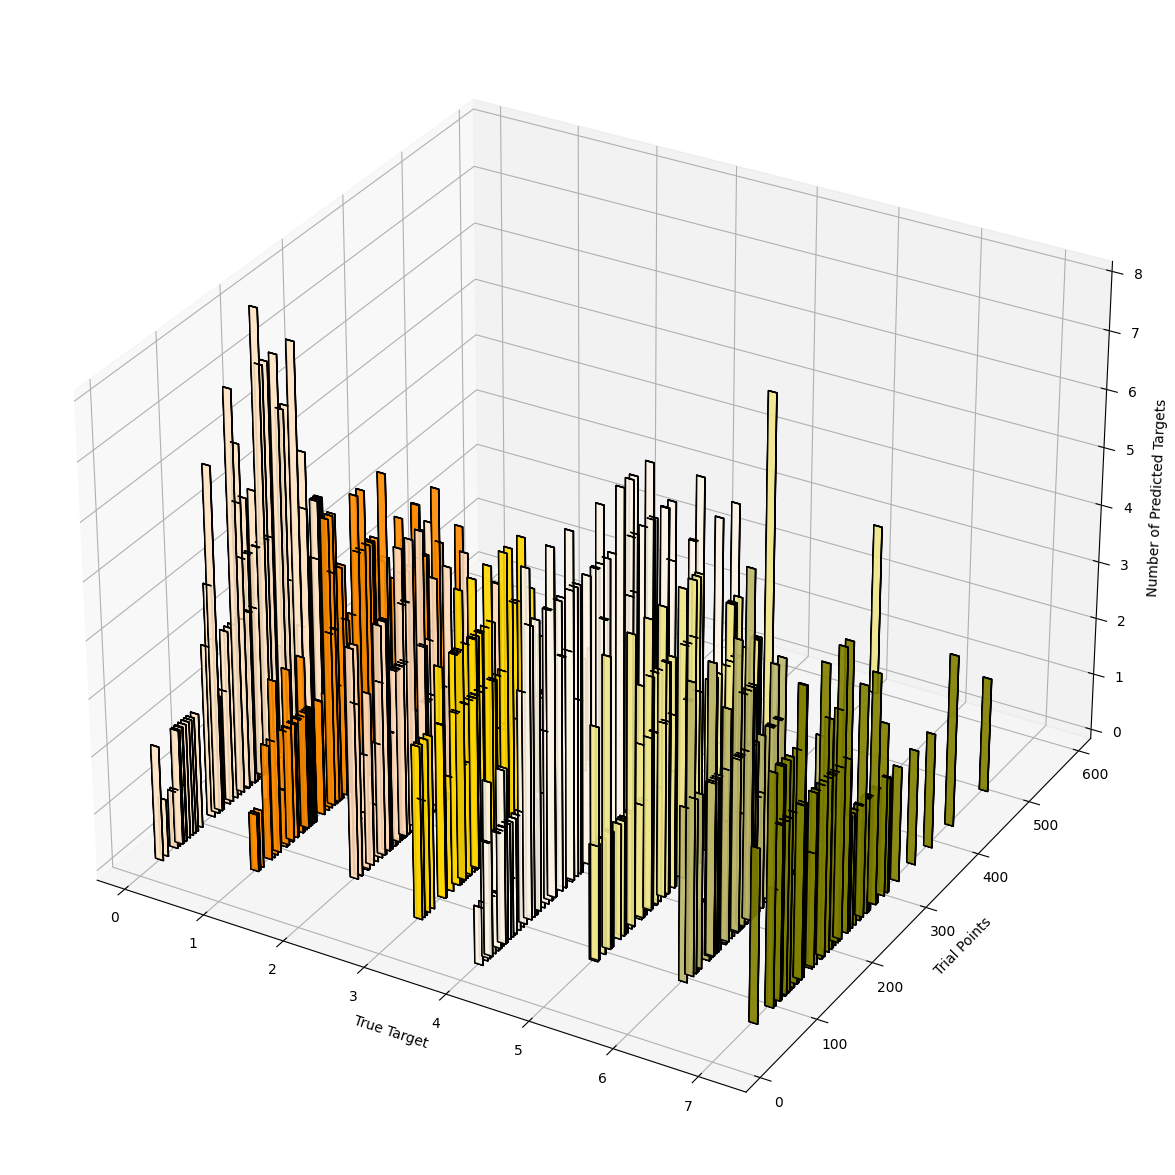

In [128]:
df = accu.copy()

width = depth = -0.1

xpos = df["target"] - width/2  # x coordinates of each bar
ypos = df["trial points"] - depth/2  # y coordinates of each bar
zpos = 0 
dz = df["#predicted targets"]

cs = ["bisque", 
        "darkorange", 
        "peachpuff", 
        "gold", 
        "oldlace", 
        "khaki", 
        "darkkhaki",
        "olive"] * len(xpos)

df["colors"] = df.apply(lambda x: cs[int(x["target"])], axis=1) 

colors = cm.tab20(np.linspace(0.5, 0.9, len(xpos)))
colors = df["colors"]

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(xpos-width, ypos+1.5*depth, zpos, width, depth*3, dz, shade=False, edgecolor = 'black', color=colors, alpha=0.7)

ax.set_xlabel("True Target")
ax.set_ylabel("Trial Points")
ax.set_zlabel("Number of Predicted Targets")
plt.savefig("../Plots/Number of predicted targets in relation to trial length")
plt.show()

### Most frequent predicted targets for each target

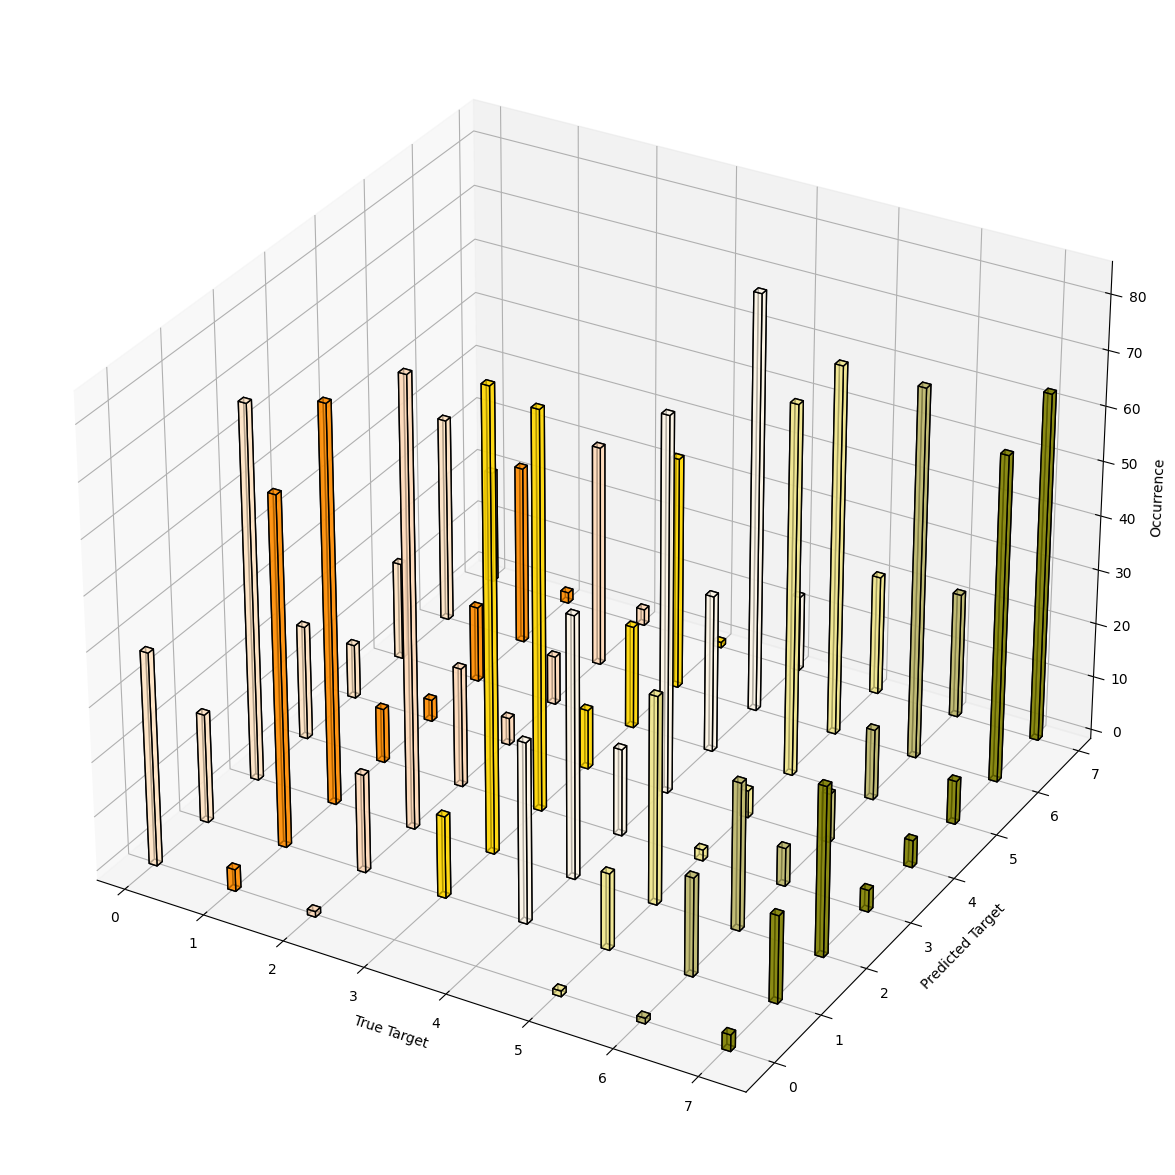

In [129]:
# most frequent predicted targets for each target
 
df = accu[["timestamp", "trial points", "accuracy", "target", "predicted targets"]].explode("predicted targets")
df = df.groupby(["target", "predicted targets"], as_index=False)["timestamp"].count()

cs = ["bisque", 
        "darkorange", 
        "peachpuff", 
        "gold", 
        "oldlace", 
        "khaki", 
        "darkkhaki",
        "olive"] * len(xpos)
df["colors"] = df.apply(lambda x: cs[int(x["target"])], axis=1) 

width = depth = -0.1

xpos = df["target"] - width/2  # x coordinates of each bar
ypos = df["predicted targets"] - depth/2  # y coordinates of each bar
zpos = 0 
dz = df["timestamp"]

colors = df["colors"]

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(xpos-width, ypos+1.5*depth, zpos, width, depth, dz, shade=False, edgecolor = 'black', color=colors, alpha=0.7)

ax.set_xlabel('True Target')
ax.set_ylabel('Predicted Target')
ax.set_zlabel('Occurrence')
plt.savefig("../Plots/Most frequent predicted targets for each target")
plt.show()

### 

In [130]:
res = accu.groupby(["target", "#predicted targets"], as_index=True)["timestamp"].count().reset_index()

res1 = accu.groupby(["target", "#predicted targets"], as_index=True).mean().reset_index()
res1["colors"] = res1.apply(lambda x: cs[int(x["target"])], axis=1) 
res1

res = pd.merge(res, res1, on = ["target", "#predicted targets"])
res.head()

C:\Users\shokoofehv\AppData\Local\Temp\ipykernel_7004\2690727908.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res1 = accu.groupby(["target", "#predicted targets"], as_index=True).mean().reset_index()


,target,#predicted targets,timestamp,trial points,accuracy,#predicted targets/length %,wrong prediction time till correct,wrong prediction time till correct/length,colors
0,0,1,4,42.5000,0.000000,2.519188,42.500000,1.000000,bisque
1,0,2,24,191.7500,0.165793,2.200198,173.125000,0.752985,bisque
2,0,3,11,166.0000,0.335165,1.955549,104.909091,0.578373,bisque
3,0,4,16,217.9375,0.144403,1.972200,169.562500,0.748233,bisque
4,0,5,4,193.2500,0.052215,2.691732,179.500000,0.912975,bisque


### Number of predicted targets for each target 

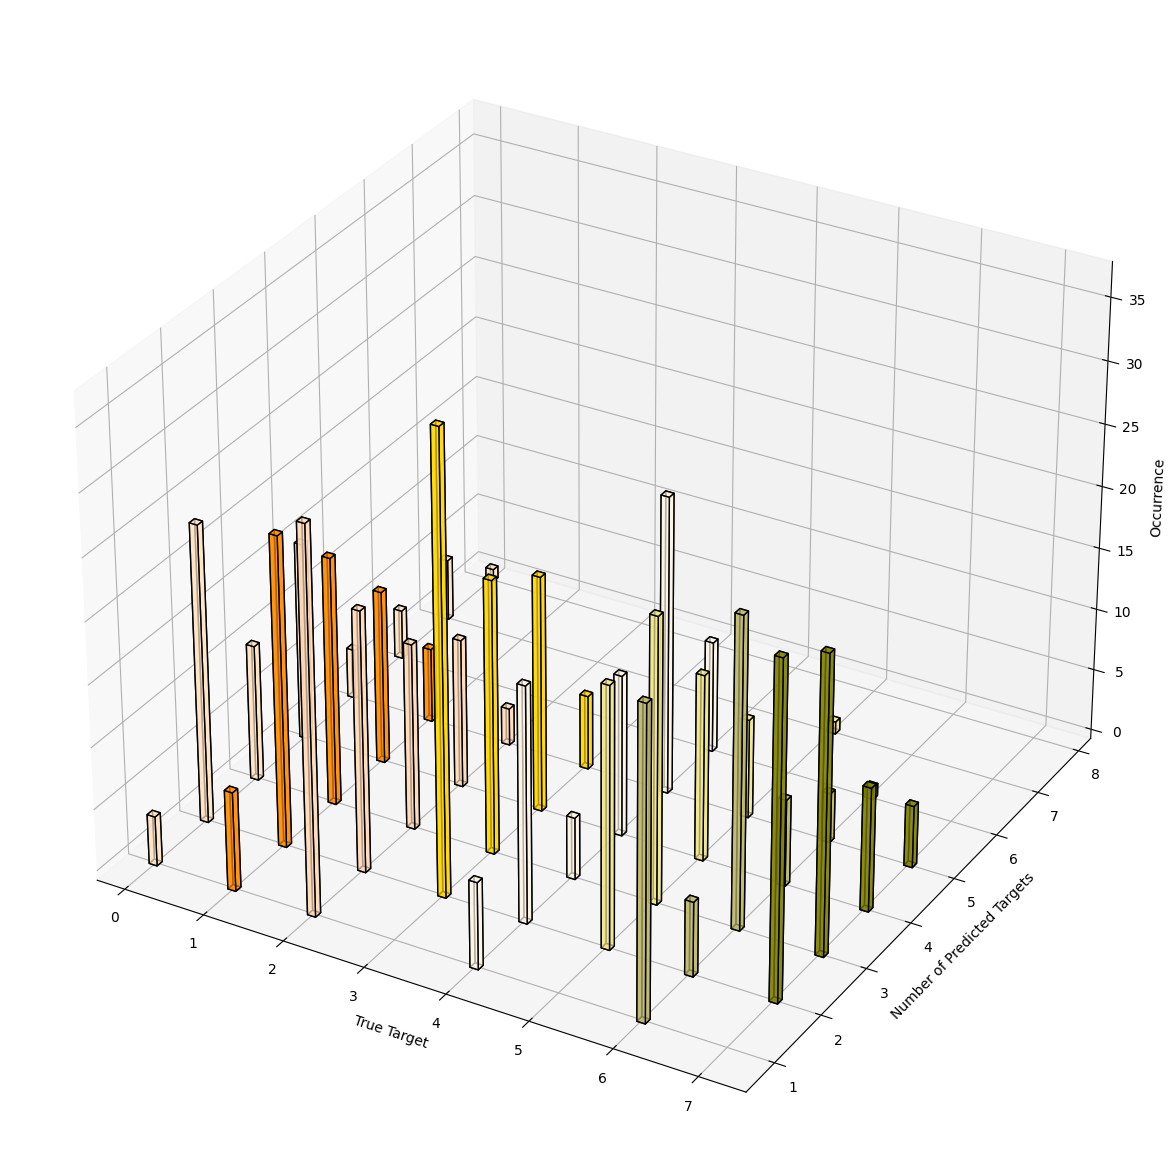

In [132]:
# number of wrong predictions 

width = depth = -0.1

xpos = res["target"] - width/2  # x coordinates of each bar
ypos = res["#predicted targets"] - depth/2  # y coordinates of each bar
zpos = 0 # z coordinates of each bar
dz = res["timestamp"]

colors = cm.tab20(np.linspace(0.5, 0.9, len(xpos)))
colors = res["colors"]
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(xpos-width, ypos+1.5*depth, zpos, width, depth, dz, shade=False, edgecolor = 'black', color=colors, alpha=0.7)

ax.set_xlabel('True Target')
ax.set_ylabel('Number of Predicted Targets')
ax.set_zlabel('Occurrence')
plt.savefig("../Plots/Number of predicted targets for each target")
plt.show()

### Avg Accuracy for each number of predicted targets and tru targets

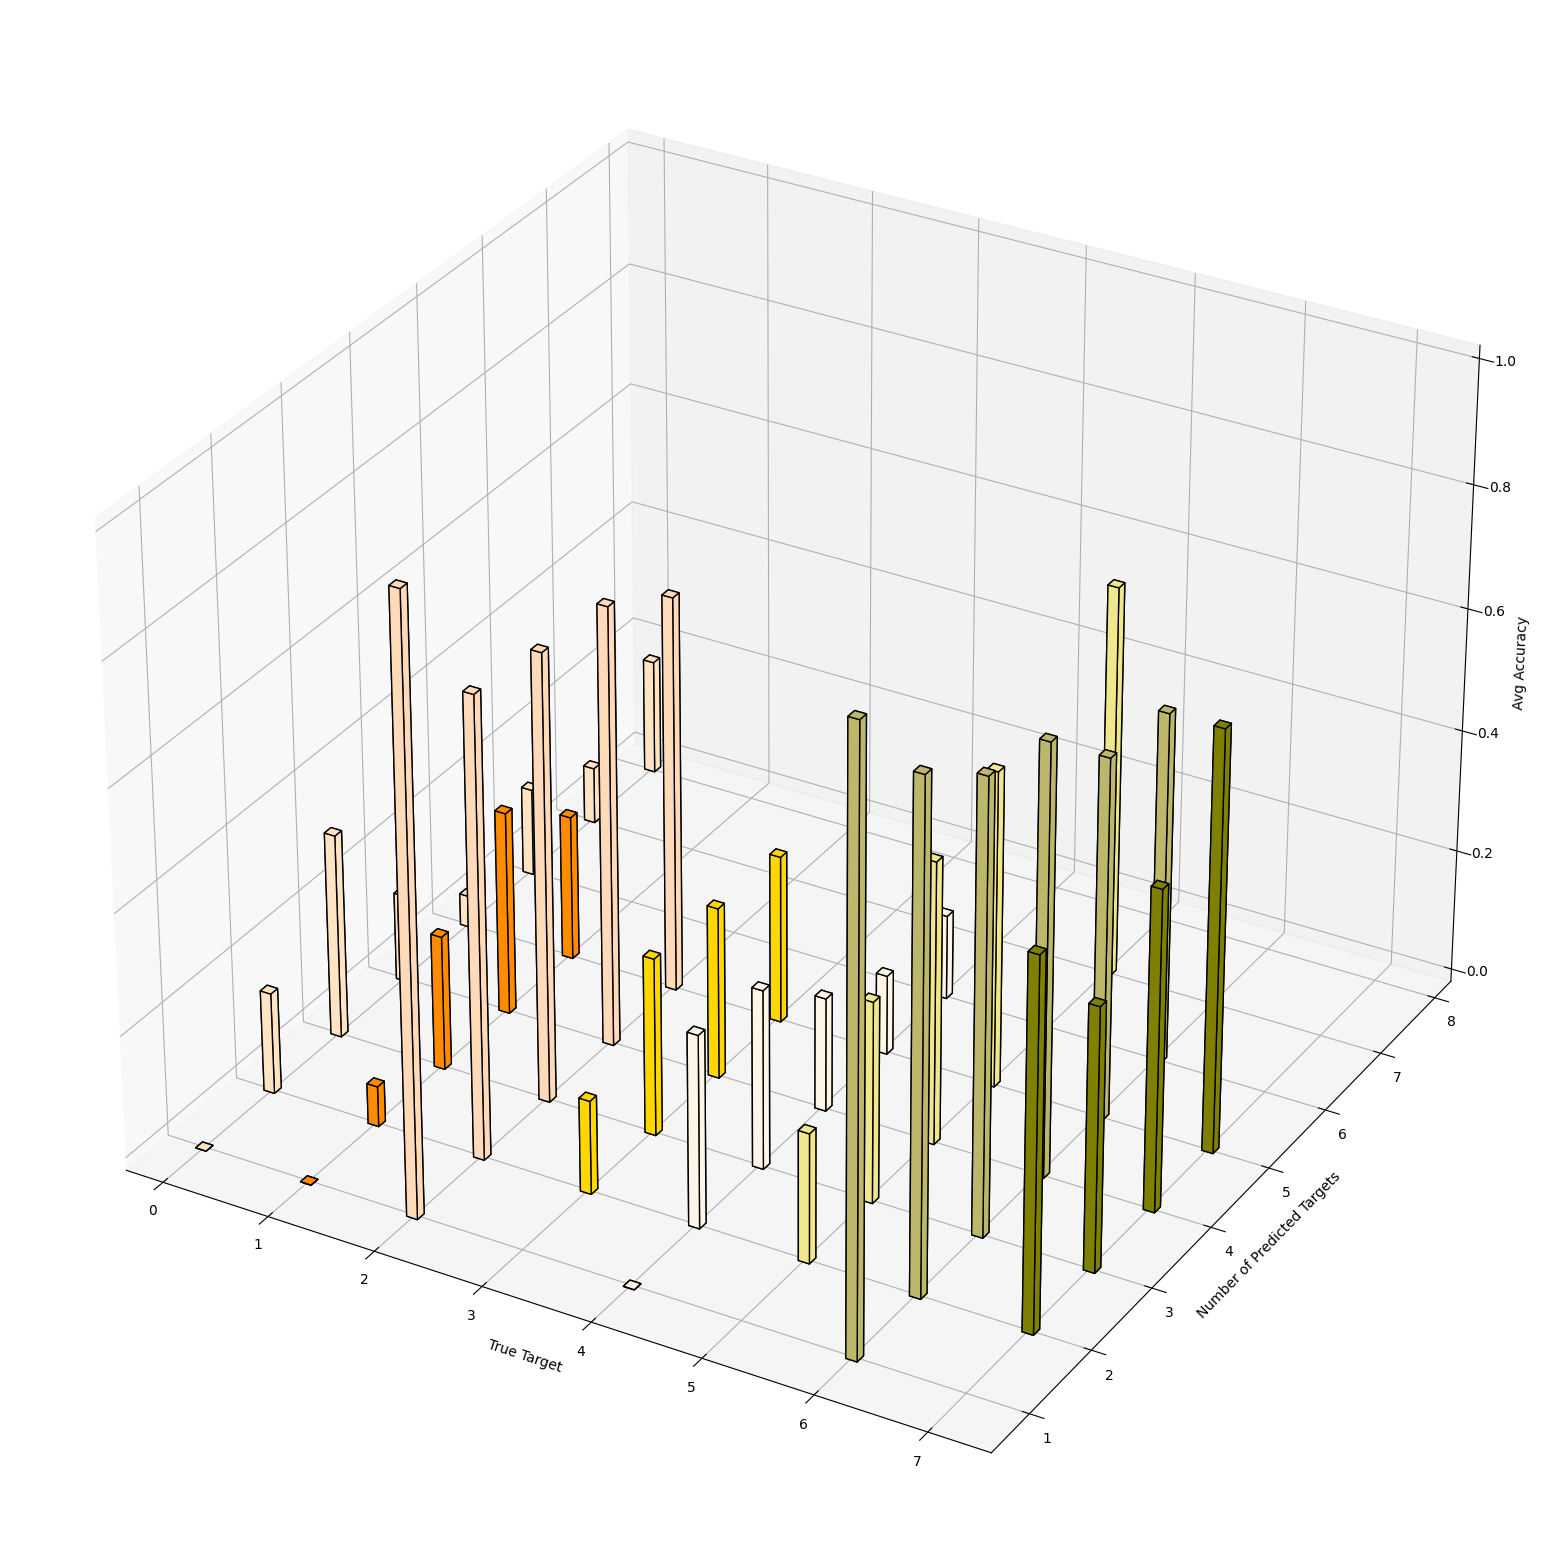

In [133]:
width = depth = -0.1

xpos = res["target"] - width/2  # x coordinates of each bar
ypos = res["#predicted targets"] - depth/2  # y coordinates of each bar
zpos = 0 # z coordinates of each bar

dz = res["accuracy"]

# cs = ['r', 'g', 'b', 'y', 'c', 'k', 'grey'] * len(xpos)
colors = cm.tab20(np.linspace(0.5, 0.9, len(xpos)))
colors = res["colors"]
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(xpos-width, ypos+1.5*depth, zpos, width, depth, dz, shade=False, edgecolor = 'black', color=colors)


ax.set_xlabel('True Target')
ax.set_ylabel('Number of Predicted Targets')
ax.set_zlabel('Avg Accuracy')
plt.savefig("../Plots/Avg Accuracy for each number of predicted targets and tru targets")
plt.show()

### Wrong prediction ratio

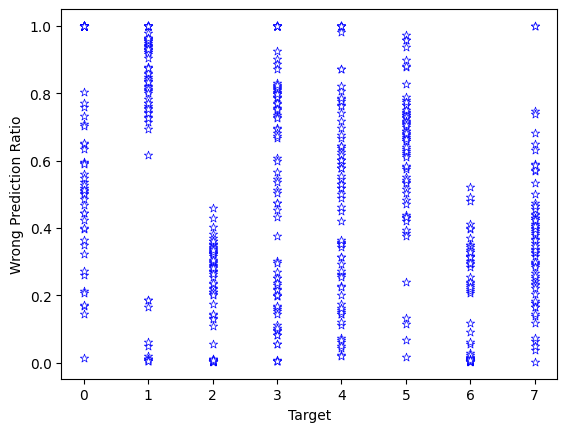

In [134]:
plt.scatter(accu["target"], accu["wrong prediction time till correct/length"],
            s=40, linewidths=.5, edgecolors='b', marker='*', c='w')
plt.xlabel("Target")
plt.ylabel("Wrong Prediction Ratio")
plt.savefig("../Plots/Wrong prediction ratio")
plt.show()

### Wrong prediction ratio and accuracy

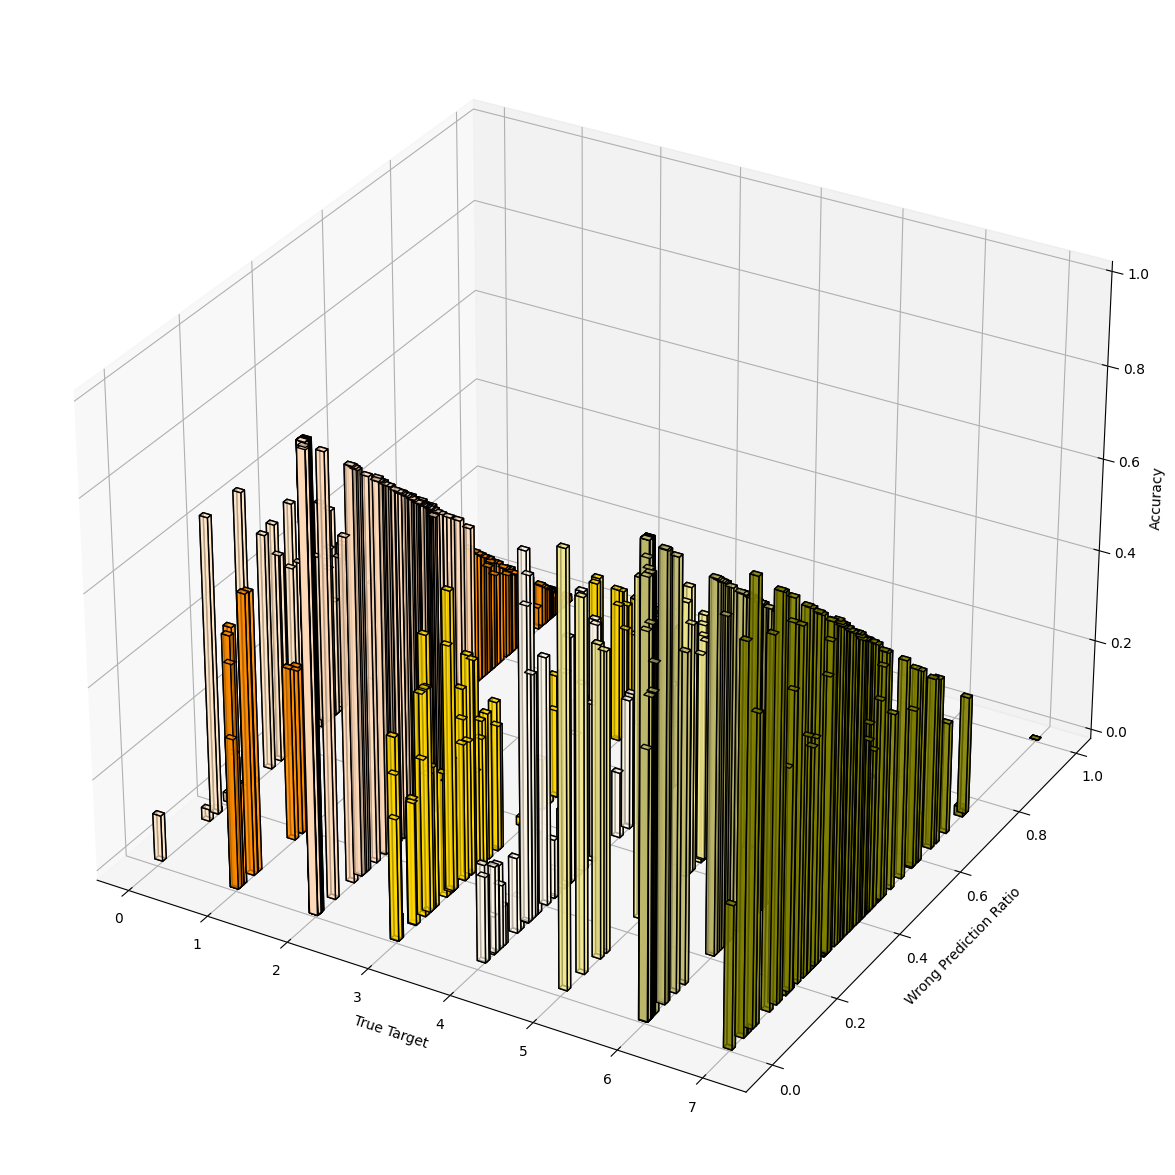

In [139]:
df = accu.copy()

width = depth = -0.1

xpos = df["target"] #- width/2  # x coordinates of each bar
ypos = df["wrong prediction time till correct/length"] #- depth/2  # y coordinates of each bar
zpos = 0 
dz = df["accuracy"]

df["colors"] = df.apply(lambda x: cs[int(x["target"])], axis=1) 

colors = cm.tab20(np.linspace(0.5, 0.9, len(xpos)))
colors = df["colors"]

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(xpos-width, ypos+depth/10, zpos, width, depth/10, dz, shade=False, edgecolor = 'black', color=colors, alpha=0.7)

ax.set_xlabel("True Target")
ax.set_ylabel("Wrong Prediction Ratio")
ax.set_zlabel("Accuracy")
plt.savefig("../Plots/Wrong prediction ratio with accuracy")
plt.show()